In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm, tqdm_notebook

%matplotlib inline

In [2]:
def cprintf(df):
    if not isinstance(df, pd.DataFrame):
        try:
            df = df.to_frame()
        except:
            raise ValueError('Object cannot be coerced to df.')
    
    print('-'*79)
    print('Data frame information')
    print('-'*79)
    print(df.tail(5))
    print('-'*50)
    print(df.info())
    print('-'*79)


In [3]:
filepath = '~/Dev/notebook/csvdata/bitfinex_BTCUSD_trades_1.csv'
cols = list(map(str.lower, ['Date','Time','Amount','Price','<Unknown>']))
columns = dict(zip(range(len(cols)), cols))

df = pd.read_csv(filepath, header = None).rename(columns = columns).assign(dates = lambda df: (pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y/%m/%d %H:%M:%S'))).assign(dollar_volume=lambda df: df['amount'] * df['price']).assign(volume=lambda df: df['amount']).drop(['date', 'time', '<unknown>'], axis = 1).set_index('dates').drop_duplicates()


In [4]:
cprintf(df)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                       amount   price  dollar_volume    volume
dates                                                         
2018-07-23 15:47:49 -0.020000  7732.2      -154.6440 -0.020000
2018-07-23 15:48:01  0.005000  7732.2        38.6610  0.005000
2018-07-23 15:48:02  0.005500  7732.2        42.5271  0.005500
2018-07-23 15:48:03  0.039241  7732.2       303.4181  0.039241
2018-07-23 15:48:06 -0.005000  7732.1       -38.6605 -0.005000
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 562899 entries, 2018-07-08 19:10:16 to 2018-07-23 15:48:06
Data columns (total 4 columns):
amount           562899 non-null float64
price            562899 non-null float64
dollar_volume    562899 non-null float64
volume           562899 non-null float64
dtypes: float64(4

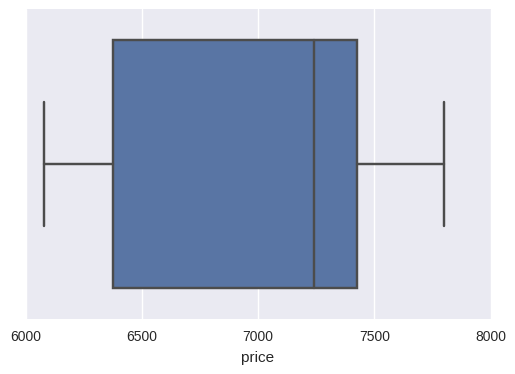

In [5]:
sns.boxplot(df.price)

In [6]:
def mad_outlier(y, thresh=3.):
    median = np.median(y)
    diff = np.sum((y-median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

In [7]:
mad = mad_outlier(df.price.values.reshape(-1, 1))
df.loc[mad]

,amount,price,dollar_volume,volume
dates,,,,


In [8]:
def tick_bars(df, price_column, m):
    t = df[price_column]
    ts = 0
    idx = []
    
    for i, x in enumerate(tqdm(t)):
        ts += 1
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
            
    return idx

def tick_bar_df(df, price_column, m):
    idx = tick_bars(df, price_column, m)
    return df.iloc[idx].drop_duplicates()

In [9]:
n_ticks = df.shape[0]
volume_ratio = df.volume.sum() / n_ticks
dollar_volume_ratio = df.dollar_volume.sum() / n_ticks

print(volume_ratio)
print(dollar_volume_ratio)

-0.0113178328244
-77.7484478463


In [10]:
tick_M = 281
tidx = tick_bars(df, 'price', tick_M)

tidx[:10]
df.iloc[tidx].shape, df.shape

tick_df = tick_bar_df(df, 'price', tick_M)
tick_df.shape

100%|██████████| 562899/562899 [00:00<00:00, 3321954.49it/s]


(2003, 4)

In [11]:
def select_sample_data(ref, sub, price_col, date):
    xdf = ref[price_col].loc[date]
    xtdf = sub[price_col].loc[date]
    return xdf, xtdf

In [12]:
def plot_sample_data(ref, sub, bar_type, *args, **kwds):
    f,axes = plt.subplots(3, sharex=True, sharey=True, figsize=(10,7))
    ref.plot(ax=axes[0], label='price', *args, **kwds)
    sub.plot(ax=axes[0], marker='.', ls='', color='r', label=bar_type, *args, **kwds)
    axes[0].legend()
    
    ref.plot(ax=axes[1], label='price', *args, **kwds)
    sub.plot(ax=axes[2], marker='.', ls='', label=bar_type, color='r', *args, **kwds)
    
    for ax in axes[1:]: 
        ax.legend()
    plt.tight_layout()
    
    return


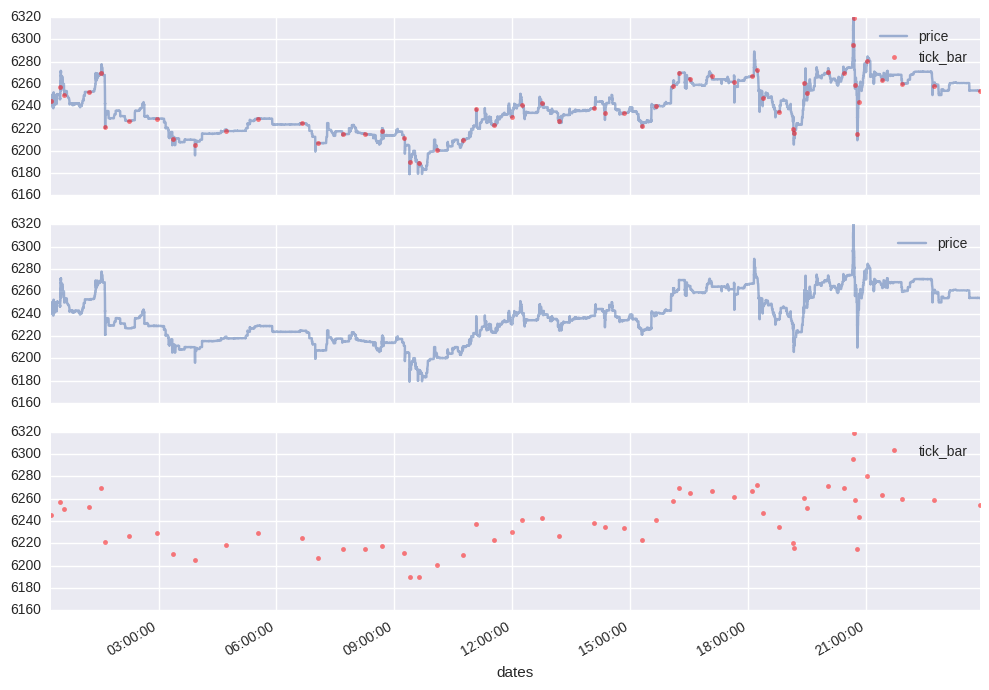

In [13]:
xDate = '2018-07-14'
xdf, xtdf = select_sample_data(df, tick_df, 'price', xDate)

xdf.shape, xtdf.shape

plot_sample_data(xdf, xtdf, 'tick_bar', alpha=0.5, markersize=7)

In [14]:
def volume_bars(df, volume_column, m):
    t = df[volume_column]
    ts = 0
    idx = []
    
    for i, x in enumerate(tqdm(t)):
        ts += math.fabs(x)
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
            
    return idx

def volume_bar_df(df, volume_column, m):
    idx = volume_bars(df, volume_column, m)
    return df.iloc[idx].drop_duplicates()

In [15]:
volume_M = 148
vidx = volume_bars(df, 'volume', volume_M)

vidx[:10]
df.iloc[vidx].shape, df.shape

volume_df = volume_bar_df(df, 'volume', volume_M)
volume_df.shape

100%|██████████| 562899/562899 [00:00<00:00, 2565769.23it/s]


(2009, 4)

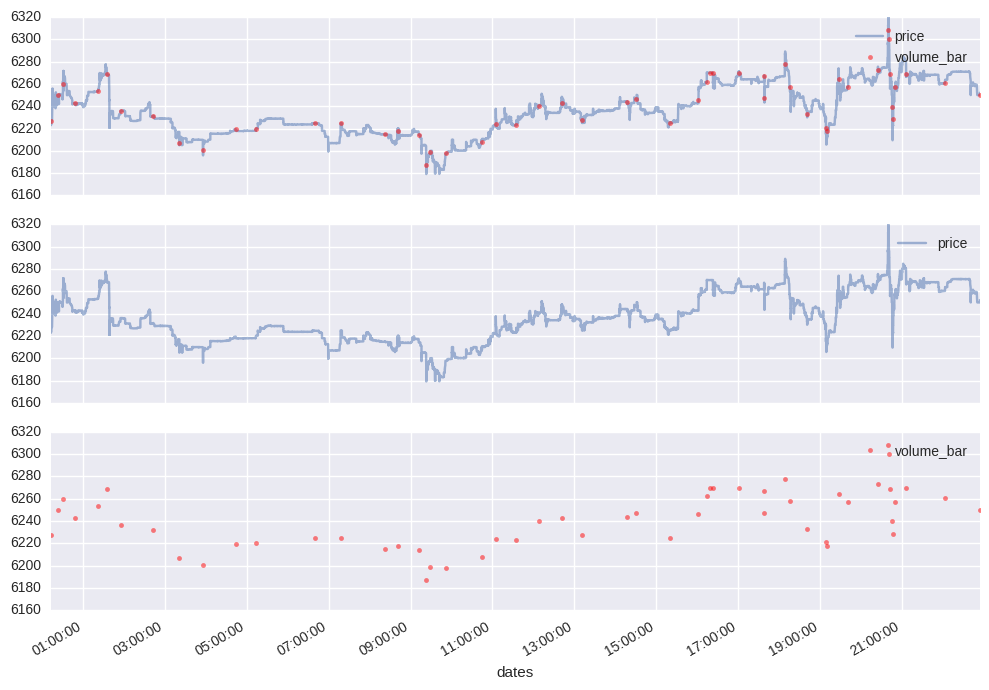

In [16]:
vDate = '2018-07-14'
vdf, vtdf = select_sample_data(df, volume_df, 'price', vDate)

vdf.shape, vtdf.shape

plot_sample_data(vdf, vtdf, 'volume_bar', alpha=0.5, markersize=7)

In [17]:
def dollar_bars(df, dollar_column, m):
    t = df[dollar_column]
    ts = 0
    idx = []
    for i, x in enumerate(tqdm(t)):
        ts += math.fabs(x)
        if ts >= m:
            idx.append(i)
            ts = 0
            continue
            
    return idx

def dollar_bar_df(df, dollar_column, m):
    idx = dollar_bars(df, dollar_column, m)    
    return df.iloc[idx].drop_duplicates()

In [40]:
dollar_M = 400000
dollar_df = dollar_bar_df(df, 'dollar_volume', dollar_M)
cprintf(dollar_df)


100%|██████████| 562899/562899 [00:00<00:00, 2506028.48it/s]55673/562899 [00:00<00:00, 2555708.77it/s]

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                        amount        price  dollar_volume     volume
dates                                                                
2018-07-23 15:25:31 -40.000000  7700.000000 -308000.000000 -40.000000
2018-07-23 15:29:11  31.444802  7700.000000  242124.976632  31.444802
2018-07-23 15:32:09   8.000000  7719.000000   61752.000000   8.000000
2018-07-23 15:36:58   0.200000  7733.000000    1546.600000   0.200000
2018-07-23 15:40:01   0.996000  7731.245984    7700.321000   0.996000
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4943 entries, 2018-07-08 19:41:28 to 2018-07-23 15:40:01
Data columns (total 4 columns):
amount           4943 non-null float64
price            4943 non-null float64
dollar_volume    4943 non-null float64
volume           

(119,)


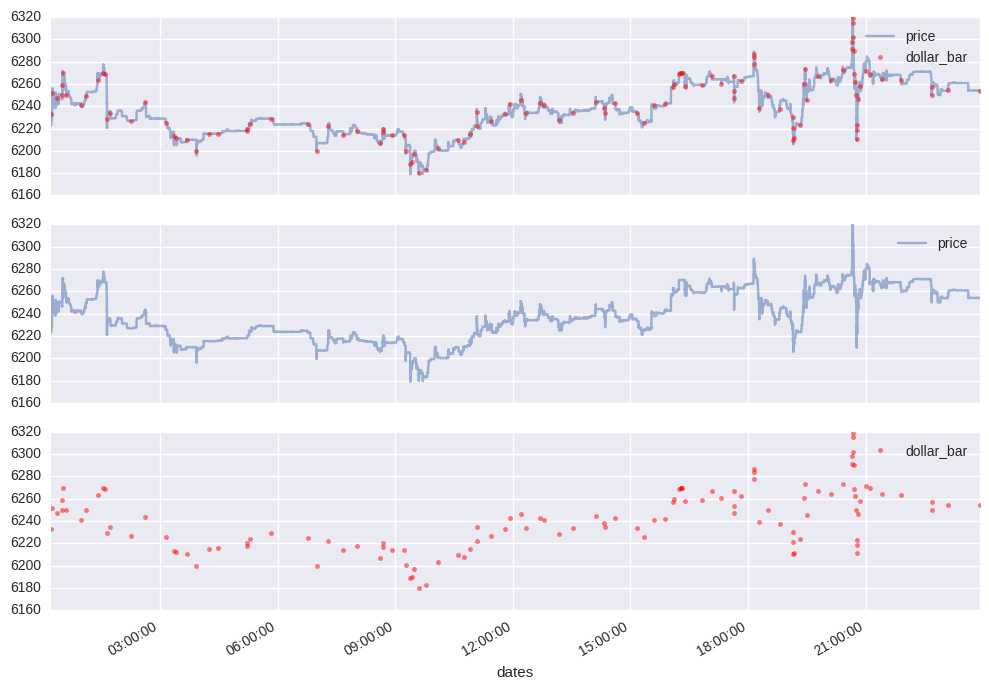

In [41]:
dDate = '2018-07-14'
ddf, dtdf = select_sample_data(df, dollar_df, 'price', dDate)

print(dtdf.shape)

plot_sample_data(ddf, dtdf, 'dollar_bar', alpha=0.5, markersize=7)

In [42]:
dollar_df.to_csv('data/dollar_bars.csv')

In [43]:
def count_bars(df, price_col='price'):
    return df.groupby(pd.TimeGrouper('1d'))[price_col].count()

def scale(s):
    return (s-s.min())/(s.max()-s.min())

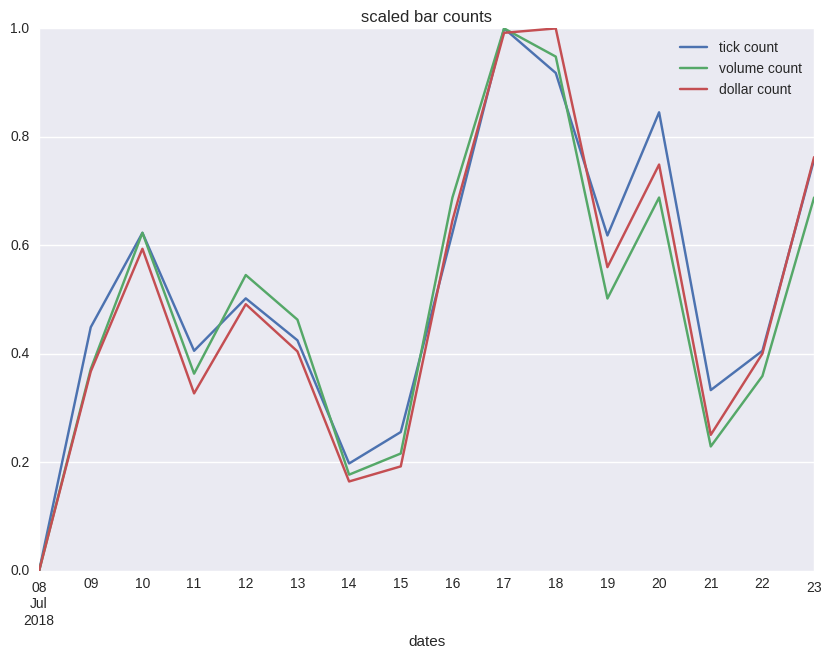

In [21]:
tc = scale(count_bars(tick_df))
vc = scale(count_bars(volume_df))
dc = scale(count_bars(dollar_df))

f,ax = plt.subplots(figsize=(10,7))

tc.plot(ax=ax, ls='-', label='tick count')
vc.plot(ax=ax, ls='-', label='volume count')
dc.plot(ax=ax, ls='-', label='dollar count')

ax.set_title('scaled bar counts')
ax.legend()

In [22]:
def returns(s):
    arr = np.diff(np.log(s))
    return pd.Series(arr, index=s.index[1:])

tr     = returns(tick_df.price)
vr     = returns(volume_df.price)
dr     = returns(dollar_df.price)
df_ret = returns(df.price)

bar_types = ['tick', 'volume', 'dollar', 'df']
bar_returns = [tr, vr, dr, df_ret]

In [23]:
def get_test_stats(bar_types_, bar_returns_, test_func_, *args, **kwds):
    dct = {bar : (int(bar_returns_.shape[0]), test_func_(bar_returns_,*args,**kwds)) for bar, bar_returns_ in zip(bar_types_, bar_returns_)}
    df = (pd.DataFrame.from_dict(dct).rename(index = {0 : 'sample_size', 1:'{test_func.__name__}_stat'}).T)
    
    return df

In [24]:
def jb(x, test=True):
    np.random.seed(12345678)
    if test: 
        return stats.jarque_bera(x)[0]
    
    return stats.jarque_bera(x)[1]

def shapiro(x, test=True):
    np.random.seed(12345678)
    if test: 
        return stats.shapiro(x)[0]
    
    return stats.shapiro(x)[1]

In [25]:
get_test_stats(bar_types, bar_returns, jb)

,sample_size,{test_func.__name__}_stat
df,562898.0,3.352806e+10
dollar,38045.0,5.896870e+06
tick,2002.0,8.563981e+02
volume,2008.0,6.225024e+02


In [26]:
get_test_stats(bar_types, bar_returns, shapiro)

/usr/local/lib/python2.7/dist-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,sample_size,{test_func.__name__}_stat
df,562898.0,0.375869
dollar,38045.0,0.805085
tick,2002.0,0.973850
volume,2008.0,0.976670


In [27]:
def bt(p0, p1, bs):    
    if np.isclose((p1-p0), 0.0, atol = 0.001):
        b = bs[-1]
        return b
    else:
        b = np.abs(p1-p0)/(p1-p0)
        return b
    
def get_imbalance(t):
    bs = np.zeros_like(t)
    for i in np.arange(1, bs.shape[0]):
        t_bt = bt(t[i-1], t[i], bs[:i])
        bs[i-1] = t_bt
        
    return bs[:-1]

In [28]:
dimbidx = get_imbalance(df.price.values) * np.abs(df.dollar_volume.iloc[1:])
cprintf(dimbidx)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     dollar_volume
dates                             
2018-07-23 15:47:49      -154.6440
2018-07-23 15:48:01         0.0000
2018-07-23 15:48:02         0.0000
2018-07-23 15:48:03         0.0000
2018-07-23 15:48:06       -38.6605
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 562898 entries, 2018-07-08 19:10:16 to 2018-07-23 15:48:06
Data columns (total 1 columns):
dollar_volume    562898 non-null float64
dtypes: float64(1)
memory usage: 8.6 MB
None
-------------------------------------------------------------------------------


In [29]:
wndo = dimbidx.shape[0] // 1000
E_bs = dimbidx.ewm(wndo).mean()

E_T = pd.Series(range(dimbidx.shape[0]), index = dimbidx.index).ewm(wndo).mean()

df0 = (pd.DataFrame().assign(bs=dimbidx).assign(E_T=E_T).assign(E_bs=E_bs).assign(absMul=lambda df: df.E_T * np.abs(df.E_bs)).assign(absTheta=dimbidx.cumsum().abs()))
cprintf(df0)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                           bs       E_T        E_bs        absMul  \
dates                                                               
2018-07-23 15:47:49 -154.6440  562331.0 -432.641668  2.432878e+08   
2018-07-23 15:48:01    0.0000  562332.0 -431.873211  2.428561e+08   
2018-07-23 15:48:02    0.0000  562333.0 -431.106118  2.424252e+08   
2018-07-23 15:48:03    0.0000  562334.0 -430.340388  2.419950e+08   
2018-07-23 15:48:06  -38.6605  562335.0 -429.644686  2.416042e+08   

                         absTheta  
dates                              
2018-07-23 15:47:49  1.145840e+07  
2018-07-23 15:48:01  1.145840e+07  
2018-07-23 15:48:02  1.145840e+07  
2018-07-23 15:48:03  1.145840e+07  
2018-07-23 15:48:06  1.145844e+07  
--------------------------------------------------
<class 'pandas.core.frame.Data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fef40e25ed0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fef40df1b90>], dtype=object)

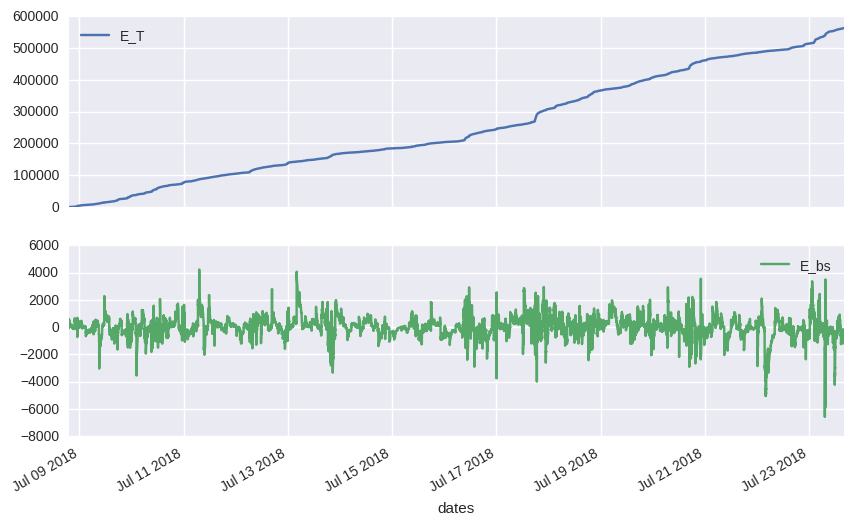

In [30]:
df0[['E_T', 'E_bs']].plot(subplots=True, figsize=(10,6))

In [31]:
df0.describe()/1000

,bs,E_T,E_bs,absMul,absTheta
count,562.898000,562.898000,562.898000,5.628980e+02,562.898000
mean,-0.020356,280.887424,-0.019751,1.726437e+05,9727.619290
std,11.460358,162.493205,0.811234,2.394189e+05,7410.298468
min,-2333.100000,0.000000,-6.586999,0.000000e+00,0.000000
25%,-0.019359,140.162250,-0.415639,2.809427e+04,2602.019301
50%,0.000000,280.886500,-0.012701,9.401148e+04,8383.904274
75%,0.013295,421.610750,0.410433,2.321033e+05,15037.485454
max,1897.956572,562.335000,4.220388,3.550853e+06,25497.686610


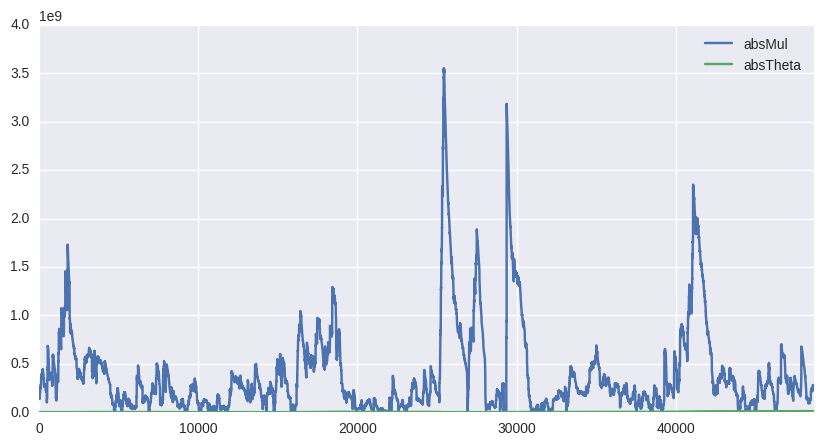

In [32]:
(df0.loc['2018-07-23', ['absMul','absTheta']].reset_index(drop=True).plot(figsize=(10,5)))

In [33]:
def test_t_abs(absTheta, t, E_bs):
    return (absTheta >= t * E_bs)

def agg_imbalance_bars(df):
    start = df.index[0]
    bars = []
    for row in df.itertuples():
        t_abs = row.absTheta
        rowIdx = row.Index
        E_bs = row.E_bs
        
        t = df.loc[start:rowIdx].shape[0]
        if t < 1: 
            t = 1
        if test_t_abs(t_abs, t, E_bs):
            bars.append((start, rowIdx, t))
            start = rowIdx
            
    return bars
        

In [37]:
bars = agg_imbalance_bars(df0)
test_imb_bars = (pd.DataFrame(bars, columns=['start', 'stop', 'Ts']).drop_duplicates())
cprintf(test_imb_bars)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                     start                stop  Ts
560953 2018-07-23 15:47:36 2018-07-23 15:47:49   2
560954 2018-07-23 15:47:49 2018-07-23 15:48:01   2
560955 2018-07-23 15:48:01 2018-07-23 15:48:02   2
560956 2018-07-23 15:48:02 2018-07-23 15:48:03   2
560957 2018-07-23 15:48:03 2018-07-23 15:48:06   2
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 293626 entries, 0 to 560957
Data columns (total 3 columns):
start    293626 non-null datetime64[ns]
stop     293626 non-null datetime64[ns]
Ts       293626 non-null int64
dtypes: datetime64[ns](2), int64(1)
memory usage: 9.0 MB
None
-------------------------------------------------------------------------------


In [39]:
test_imb_bars.Ts.describe().round()

count    293626.0
mean          5.0
std           9.0
min           2.0
25%           2.0
50%           3.0
75%           5.0
max        2030.0
Name: Ts, dtype: float64

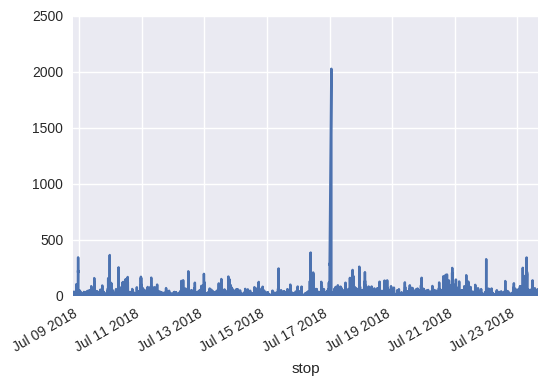

In [40]:
test_imb_bars.set_index('stop')['Ts'].plot()

In [41]:
dimbbars = df.price.loc[test_imb_bars.stop].drop_duplicates()
cprintf(dimbbars)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                           price
dates                           
2018-07-23 15:45:25  7728.291211
2018-07-23 15:46:01  7726.886450
2018-07-23 15:46:42  7728.525338
2018-07-23 15:46:43  7728.700000
2018-07-23 15:46:55  7729.695972
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38046 entries, 2018-07-08 19:10:16 to 2018-07-23 15:46:55
Data columns (total 1 columns):
price    38046 non-null float64
dtypes: float64(1)
memory usage: 594.5 KB
None
-------------------------------------------------------------------------------


In [42]:
dbars = dollar_df.price
cprintf(dbars)

-------------------------------------------------------------------------------
Data frame information
-------------------------------------------------------------------------------
                           price
dates                           
2018-07-23 15:41:29  7726.300000
2018-07-23 15:41:52  7726.300000
2018-07-23 15:43:07  7731.400000
2018-07-23 15:44:36  7731.300000
2018-07-23 15:46:42  7728.525338
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38046 entries, 2018-07-08 19:12:10 to 2018-07-23 15:46:42
Data columns (total 1 columns):
price    38046 non-null float64
dtypes: float64(1)
memory usage: 594.5 KB
None
-------------------------------------------------------------------------------


In [47]:
dr = returns(dbars)
drimb = returns(dimbbars)

print(dr.shape)
print(drimb.shape)

(38045,)
(38045,)


In [65]:
bar_types0 = ['dollar', 'dollar imbalance']
bar_rets0 = [dr, drimb]

In [66]:
get_test_stats(bar_types0, bar_rets0, jb)

,sample_size,{test_func.__name__}_stat
dollar,38045.0,5.896870e+06
dollar imbalance,38045.0,6.296563e+06


In [67]:
get_test_stats(bar_types0, bar_rets0, shapiro)

,sample_size,{test_func.__name__}_stat
dollar,38045.0,0.805085
dollar imbalance,38045.0,0.738339
